<h1><center>Notebook 3 : Weather regime index and life-cycles </center></h1>

<h2>Instructions for this notebook</h2>


This notebook was written by Paul Platzer. It accompanies the following scientific publication:<br>
"Weather Regime Dimensions: from Random to Multi-fractal"<br>
By Paul Platzer, Bertrand Chapron, and Gabriele Messori.<br>
<b> add doi, date...etc. </b>

It is part of six notebooks that allow to reproduce the figures of the article. It must be used in conjunction with 500mb geopotential height data from ERA5 (last download from october 18th, 2023), as specified in the body text of the article.

What this notebook does:

<ol>
    <li> It opens preprocessed ERA5 data (10day-smoothed anomalies projected on winter-time EOFs), the results of the GMM fit, and the stochastic twins.</li>
    <li> It computes weather-regime indices base don ERA5 projected data, stochastic twin data, and GMM fit parameters. </li>
    <li> It saves computed weather-regime indices. </li>
    <li> It computes average weather regime indices around maximums, and for a minimum duration of 5 days. </li>
    <li> It plots and saves figures of the above. </li>
</ol>

To use properly this notebook, you must:

<ol>
    <li> Have previously run "Notebook0-ERA5_pretreatment.ipynb", "Notebook1-GMM_fit.ipynb" and "Notebook2-Stochastic_twin_generation.ipynb".</li>
    <li> Run the whole notebook once.</li>
    <li> If you have already run the notebook, and you just want to replot the figures, you can skip section III. </li>
</ol>

Note that, for this code to work on your machine, you should:

<ol>
    <li> Have download the libraries listed in the first two cells. </li>
    <li> Use python 3 : this code was tested using python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0] </li>
    <li> Have enough memory and computing resources. If not, you might have to modify the code to make it work. The code was run using a Dell Inc. Precision 7550 which has 33G of RAM and setting the same amount of swap space, and for processing we have Intel® Core™ i7-10875H CPU @ 2.30GHz × 16, with graphics card NVIDIA Corporation TU104GLM [Quadro RTX 4000 Mobile / Max-Q] / Mesa Intel® UHD Graphics (CML GT2). </li>
</ol>

In [1]:
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

In [2]:
cols = ['k', '#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [3]:
data_folder = '../outputs/data/'
figure_folder = '../outputs/figures/'

# I. Load preprocessed ERA5, GMM parameters, and stochastic twins

In [4]:
# load
smooth = True
npzfile = np.load(data_folder + 'GMM_params.npz')
means = npzfile['means']
covs = npzfile['covs']
weights = npzfile['weights']
nclus = npzfile['nclus']
cov_type = npzfile['cov_type']
ndim_gmm = npzfile['ndim_gmm']
random_state_gmm = npzfile['random_state_gmm']
regime_names = npzfile['regime_names']
regime_short_names = npzfile['regime_short_names']
regime_attribution = npzfile['regime_attribution']
regime_attribution_distance = npzfile['regime_attribution_distance']
Ndays = npzfile['Ndays']
Ndays_kmeans = npzfile['Ndays_kmeans']
Ndays_tot = npzfile['Ndays_tot']

In [5]:
allpcs = xr.open_dataset(data_folder + 'pcs.nc')['pseudo_pcs']
eofs = xr.open_dataset(data_folder + 'eofs.nc')['eofs']
pourc_EOF = xr.open_dataset(data_folder + 'pourc_eofs.nc')['variance_fractions']

In [6]:
# normalize pcs but keep relative variances
pcs_norm = allpcs / (allpcs.sel(mode=0)).std(dim='time')

In [9]:
npzfile = np.load(data_folder + 'stoch_twins.npz')
X = npzfile['X']
ndim_gmm = npzfile['ndim_gmm']
rho = npzfile['rho']
scaling = npzfile['scaling']
Ntwins = X.shape[0]
L = X.shape[1]

# II. Compute weather regime index (WRI)

In [10]:
index = np.zeros( ( Ntwins , L , len(means) ) ,  dtype='float64')
for k in range(Ntwins):
    for i in range(len(means)):
        index[k,:,i] = np.sum( X[k][:,:ndim_gmm]*means[i] , axis=1)
        index[k,:,i] -= np.mean( index[k,:,i] )
        index[k,:,i] /= np.std( index[k,:,i] )    

In [11]:
c_index = np.zeros( ( Ntwins , L , len(means) ) ,  dtype='float64')
for k in range(Ntwins):
    for i in range(len(means)):
        c_index[k,:,i] = np.einsum( 'ij,jk,ik->i' , X[k][:,:ndim_gmm]-means[i] ,
                                   np.linalg.inv(covs[i]) , X[k][:,:ndim_gmm]-means[i] )

In [12]:
index_nat = np.zeros( ( len(pcs_norm), len(means) ) ,  dtype='float64')
for i in range(len(means)):
    index_nat[:,i] = np.sum( np.array(pcs_norm[:,:ndim_gmm])*means[i] , axis=1)
    index_nat[:,i] -= np.mean( index_nat[:,i] )
    index_nat[:,i] /= np.std( index_nat[:,i] )

In [13]:
c_index_nat = np.zeros( ( len(pcs_norm) , len(means) ) ,  dtype='float64')
for i in range(len(means)):
    c_index_nat[:,i] = np.einsum( 'ij,jk,ik->i' , pcs_norm[:,:ndim_gmm]-means[i] ,
                                 np.linalg.inv(covs[i]) , pcs_norm[:,:ndim_gmm]-means[i] )

# III. Save if needed

In [14]:
np.savez(data_folder + 'WRI_nat.npz', 
         index_nat = index_nat,
         c_index_nat = c_index_nat, )

In [15]:
np.savez(data_folder + 'WRI_twins.npz', 
         index = index,
         c_index = c_index,)

# IV. Average WRI around maximum index

Stochastic twin

In [25]:
# minimum length of life-cycle
LC_length = 5*2
# minimum value of IWR for life-cycle definitino
thresh_IWR = 1
# (half of whole) length over which to plot characteristics
plot_length = 15*2
t_plot = np.arange( - plot_length , plot_length + 1 ) / 2

IWR_plot_twins = []

for k in tqdm(range(Ntwins)):

    IWR_plot = []

    for i_regime in range(len(means)):
        IWR_plot__ = []
        t = np.array(plot_length) + 5
        while t < int(L) - 10 - max(LC_length , plot_length + 1):
            t += 1
            if np.product( index[k,t:t+LC_length,i_regime] > thresh_IWR ):
                t_start = t.copy()
                t_end = t_start+LC_length
                while index[k,t_end,i_regime] > thresh_IWR and t_end + 1 < L :
                    t_end += 1
                t_max = t_start + np.argmax(index[k,t_start:t_end,i_regime])

                if t_max < int(L) + 1 - plot_length:

                    IWR_plot__.append( index[k,t_max-plot_length:t_max+plot_length+1] )

                t = t_end.copy()

        IWR_plot.append( IWR_plot__ )

    IWR_plot_twins.append( IWR_plot )

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
# Intra-twin statistics
IWR_mean_twins = np.zeros( ( Ntwins , nclus , len(t_plot) , nclus ) , dtype='float64' )
IWR_std_twins = np.zeros( ( Ntwins , nclus , len(t_plot) , nclus ) , dtype='float64' )

for k in range(Ntwins):
    for i in range(nclus):
        IWR_mean_twins[k,i] = np.mean( np.array(IWR_plot_twins[k][i]) , axis=0 )
        IWR_std_twins[k,i] = np.std( np.array(IWR_plot_twins[k][i]) , axis=0 )     
        

In [27]:
# merge all twins

IWR_plot_twins_concat = []
dd_plot_twins_concat = []


for i_regime in range(len(means)):
    IWR_plot_twins_concat__ = []
    
    for k in range(Ntwins):
        for l in range(len(IWR_plot_twins[k][i_regime])):
            IWR_plot_twins_concat__.append( IWR_plot_twins[k][i_regime][l] )

    IWR_plot_twins_concat.append( IWR_plot_twins_concat__ )


True data

In [28]:
IWR_plot_nat = []
    
for i_regime in range(len(means)):
    IWR_plot__ = []
    t = np.array(plot_length) + 5
    while t < int(L) - 5 - max(LC_length , plot_length + 1):
        t += 1
        if np.product( index_nat[t:t+LC_length,i_regime] > thresh_IWR ):
            t_start = t.copy()
            t_end = t_start+LC_length
            while index_nat[t_end,i_regime] > thresh_IWR and t_end + 1 < L :
                t_end += 1
            t_max = t_start + np.argmax(index_nat[t_start:t_end,i_regime])
            
            if t_max < int(L) + 1 - plot_length:
                
                IWR_plot__.append( index_nat[t_max-plot_length:t_max+plot_length+1] )
            
            t = t_end.copy()
    
    IWR_plot_nat.append( IWR_plot__ )


# V. Plot

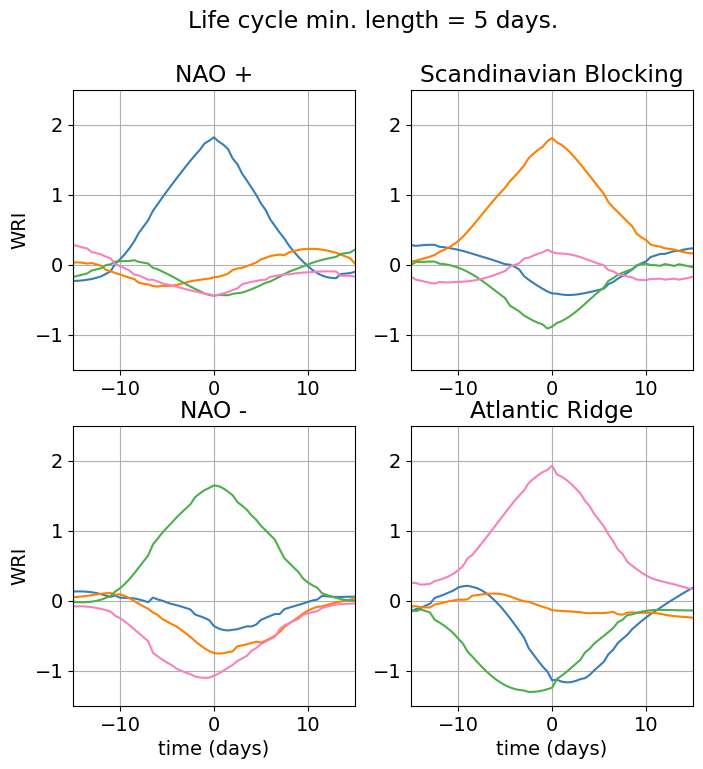

In [36]:
plt.figure(figsize=(8,8),dpi=100)
for i_regime in range(len(weights)):
    plt.subplot(221+i_regime)
    
#     plt.plot([-plot_length/2,plot_length/2] , [0]*2, '-', color='.5', alpha=.5)
    
    for j_regime in range(len(weights)):
        plot_mean = np.mean( np.array(IWR_plot_nat[i_regime])[:,:,j_regime] , axis = 0)
        plt.plot(t_plot, plot_mean, '-', color=cols[j_regime+1])
            
    plt.xlabel('time (days)'*( i_regime > 1 ))
    plt.ylabel('WRI'*( i_regime % 2 == 0 ))
    plt.ylim([-1.5,2.5])
    plt.xlim([-plot_length/2,plot_length/2])
    plt.title(regime_names[i_regime])
    plt.grid()

plt.suptitle('Life cycle min. length = '+str(int(LC_length/2))+' days.')
plt.savefig( figure_folder + 'WRI_life_cycle_' + str(int(LC_length/2)) + 'days.png' , dpi=150 , bbox_inches='tight' )
plt.show()

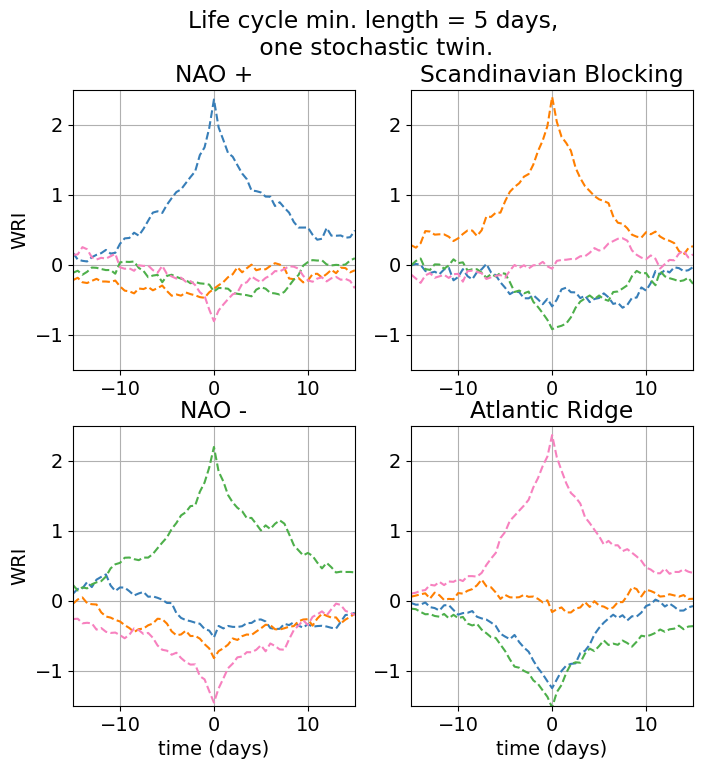

In [37]:
plt.figure(figsize=(8,8),dpi=100)
for i_regime in range(len(weights)):
    plt.subplot(221+i_regime)
    
#     plt.plot([-plot_length/2,plot_length/2] , [0]*2, '-', color='.5', alpha=.5)
    
    for j_regime in range(len(weights)):
        plot_mean = np.mean( np.array(IWR_plot_twins[0][i_regime])[:,:,j_regime] , axis = 0)
        plt.plot(t_plot, plot_mean, '--', color=cols[j_regime+1])
            
    plt.xlabel('time (days)'*( i_regime > 1 ))
    plt.ylabel('WRI'*( i_regime % 2 == 0 ))
    plt.ylim([-1.5,2.5])
    plt.xlim([-plot_length/2,plot_length/2])
    plt.title(regime_names[i_regime])
    plt.grid()

plt.suptitle('Life cycle min. length = '+str(int(LC_length/2))+' days,\n one stochastic twin.')
plt.savefig( figure_folder + 'WRI_life_cycle_1twin' + str(int(LC_length/2)) + 'days.png' , dpi=150 , bbox_inches='tight' )
plt.show()

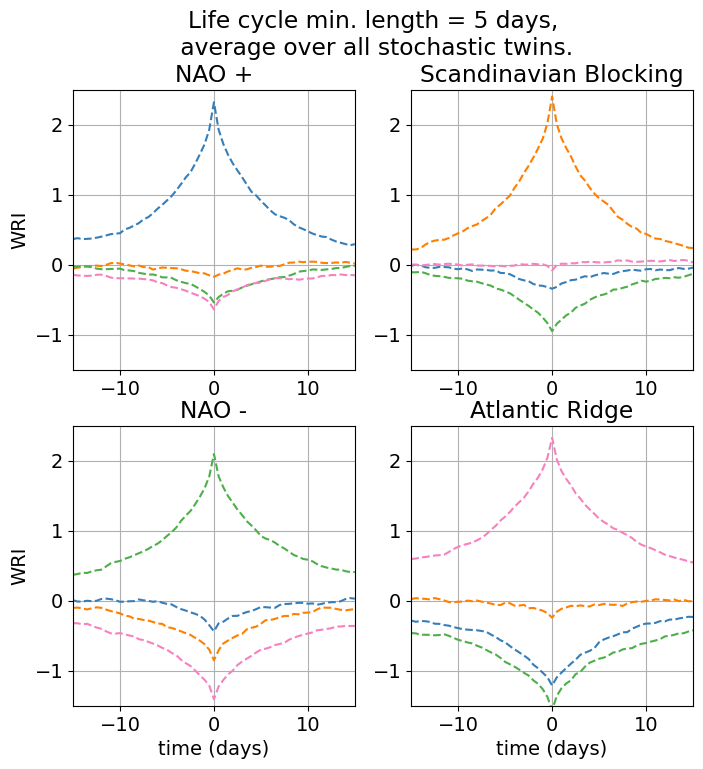

In [39]:
plt.figure(figsize=(8,8),dpi=100)
for i_regime in range(len(weights)):
    plt.subplot(221+i_regime)
    
#     plt.plot([-plot_length/2,plot_length/2] , [0]*2, '-', color='.5', alpha=.5)
    
    for j_regime in range(len(weights)):
        plot_mean = np.mean( np.array(IWR_plot_twins_concat[i_regime])[:,:,j_regime] , axis = 0)
        plt.plot(t_plot, plot_mean, '--', color=cols[j_regime+1])
            
    plt.xlabel('time (days)'*( i_regime > 1 ))
    plt.ylabel('WRI'*( i_regime % 2 == 0 ))
    plt.ylim([-1.5,2.5])
    plt.xlim([-plot_length/2,plot_length/2])
    plt.title(regime_names[i_regime])
    plt.grid()

plt.suptitle('Life cycle min. length = '+str(int(LC_length/2))+' days,\n average over all stochastic twins.')
plt.savefig( figure_folder + 'WRI_life_cycle_all_twins' + str(int(LC_length/2)) + 'days.png' , dpi=150 , bbox_inches='tight' )
plt.show()